<a href="https://colab.research.google.com/github/pallavi17798/crop-stage-detection/blob/main/CropStageDetection%26Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee  # Google Earth Engine
import numpy as np
import tensorflow as tf
from scipy.fft import fft
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-pallavisharma')

In [ ]:
# Load your feature collection from Google Earth Engine asset
aoi_fc = ee.FeatureCollection("projects/ee-pallavisharma/assets/fatehabd-cotton")
aoi = aoi_fc.geometry()


In [ ]:
# Define the time range
start_date = '2021-12-01'
end_date = '2023-12-01'

def mask_s2_clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloud_bit_mask).eq(0) \
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

  return image.updateMask(mask).divide(10000)

#.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",10))
# Fetch Sentinel-2 data using Google Earth Engine
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate(start_date, end_date)
              .select(['B2', 'B3', 'B4', 'B8','B5','B11','B12','QA60']).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",1)).filterBounds(aoi)) # Adjust bands as needed

collection.map(mask_s2_clouds)
# Function to convert DN to reflectance
def dn_to_reflectance(image):
    return image.multiply(0.0001)  # Scaling factor for Sentinel-2 data

# Map the conversion function over the collection
collection_refl = collection.map(dn_to_reflectance)

# If only one image covers the AOI, use that image directly
if collection.size().getInfo() == 1:
    mosaic = ee.Image(collection.first())
else:
    # If multiple tiles are present, mosaic the collection
    mosaic = collection.median()


In [ ]:
# If only one image covers the AOI, use that image directly
if collection.size().getInfo() == 1:
    mosaic = ee.Image(collection.first())
else:
    # If multiple tiles are present, mosaic the collection

    mosaic = collection.median()

In [ ]:
# Function to calculate vegetation indices
def calculate_indices(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  savi = image.expression('((NIR - Red) / (NIR + Red + L))*(1 + L)  ', {
        'NIR': image.select('B8'),
        'Red': image.select('B4'),
        'L': 0.428
    }).rename('SAVI')

  ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
  ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
  ndti = image.normalizedDifference(['B11', 'B12']).rename('NDTI')

  return image.addBands([ndvi, savi, ndre, ndmi, ndti])

# Map the index calculation function over the collection
collection_with_indices = collection.map(calculate_indices)

# Convert the collection to a list and retrieve the data
timestamps = collection_with_indices.aggregate_array('system:time_start').getInfo()
ndvi_values = collection_with_indices.aggregate_array('NDVI').getInfo()
savi_values = collection_with_indices.aggregate_array('SAVI').getInfo()
ndre_values = collection_with_indices.aggregate_array('NDRE').getInfo()
ndmi_values = collection_with_indices.aggregate_array('NDMI').getInfo()
ndti_values = collection_with_indices.aggregate_array('NDTI').getInfo()

# Create an empty DataFrame with column names
column_names = ['NDVI', 'SAVI', 'NDRE', 'NDMI', 'NDTI']
df = pd.DataFrame(columns=['Timestamp'] + column_names)
df.set_index('Timestamp', inplace=True)
df[column_names] = df[column_names].round(3)

# Loop through the collection and calculate indices for each image
for image in collection_with_indices.getInfo()['features']:
    image_id = image['id']
    image_obj = ee.Image(image_id)  # Create an Earth Engine Image object

    # Calculate vegetation indices
    indices_image = calculate_indices(image_obj)

    # Get timestamp
    timestamp = pd.to_datetime(image['properties']['system:time_start'], unit='ms')

    # Get index values
    index_values = indices_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10
    ).getInfo()

    # Add the index values to the DataFrame
    df.loc[timestamp] = [index_values[band] for band in column_names]

df.head()

,NDVI,SAVI,NDRE,NDMI,NDTI
Timestamp,,,,,
2021-12-03 05:50:46.355,0.286768,0.409456,0.179483,0.004293,0.112689
2021-12-08 05:50:49.780,0.417853,0.596619,0.268513,0.121492,0.151366
2021-12-18 05:50:51.466,0.477048,0.681147,0.317257,0.175462,0.157491
2022-01-27 05:50:51.113,0.571965,0.816680,0.383360,0.292717,0.232209
2022-02-11 05:50:45.199,0.529861,0.756564,0.363752,0.286055,0.163350


In [ ]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df.index)

# Extract only the date part (yyyy-mm-dd)
df['Date'] = df['Timestamp'].dt.date

# Drop the original 'Timestamp' column if needed
df.drop(columns=['Timestamp'], inplace=True)


In [ ]:
# Convert the index to a DatetimeIndex (if it's not already)
df.index = pd.to_datetime(df.index)

# Create a new 'Date' column from the index
df['Date'] = df.index.date

# Drop duplicates from the 'Date' column to keep only unique dates
df.drop_duplicates(subset='Date', keep='first', inplace=True)

# Set the 'Date' column as the new index
df.set_index('Date', inplace=True)

# Now, you have a DataFrame with the 'Date' column as the index, containing unique date values.
print(df)

                NDVI      SAVI      NDRE      NDMI      NDTI
Date                                                        
2021-12-03  0.286768  0.409456  0.179483  0.004293  0.112689
2021-12-08  0.417853  0.596619  0.268513  0.121492  0.151366
2021-12-18  0.477048  0.681147  0.317257  0.175462  0.157491
2022-01-27  0.571965  0.816680  0.383360  0.292717  0.232209
2022-02-11  0.529861  0.756564  0.363752  0.286055  0.163350
2022-02-16  0.564299  0.805724  0.358620  0.271051  0.231001
2022-02-21  0.583866  0.833665  0.380832  0.293458  0.186529
2022-03-13  0.586744  0.837773  0.329160  0.244066  0.181861
2022-03-18  0.436762  0.623627  0.263704  0.116543  0.145217
2022-03-28  0.359439  0.513220  0.219907  0.080084  0.125894
2022-04-02  0.292138  0.417126  0.186195  0.000498  0.070502
2022-04-07  0.266360  0.380324  0.166947 -0.025089  0.091401
2022-04-22  0.296584  0.423479  0.174288 -0.063569  0.051882
2022-04-27  0.325978  0.465432  0.184533 -0.046387  0.080241
2022-05-02  0.259076  0.

In [ ]:
import plotly.graph_objs as go

# Create traces for NDVI and NDMI
trace_ndvi = go.Scatter(x=df.index, y=df['NDVI'], mode='lines', name='NDVI')
trace_ndmi = go.Scatter(x=df.index, y=df['NDMI'], mode='lines', name='NDMI')

# Create the figure
fig = go.Figure(data=[trace_ndvi, trace_ndmi])

# Update layout
fig.update_layout(
    title='NDVI and NDMI Values Over Time',
    xaxis_title='Date',
    yaxis_title='Index Values'
)

fig.show()



In [ ]:
df.to_csv('indices1.csv')

## Data Frame Pre-Processing

In [ ]:
from sklearn.preprocessing import StandardScaler
dataf1=pd.read_csv('indices1.csv')

dataf1.head()

dataf1['Date'] = pd.to_datetime(dataf1['Date'])  # Convert the 'date' column to datetime format
dataf1.set_index('Date', inplace=True)  # Set the 'date' column as the index

dataf1.head()

dataf1 = dataf1.dropna()
dataf1.head()
dataf1.to_csv('veg_indices_df1.csv')

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



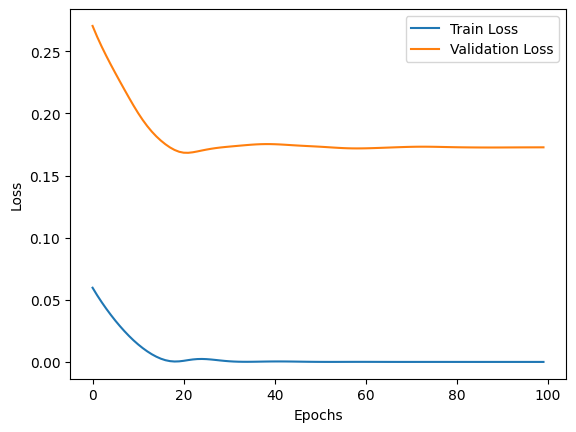

34/34 [==============================] - 0s 3ms/step


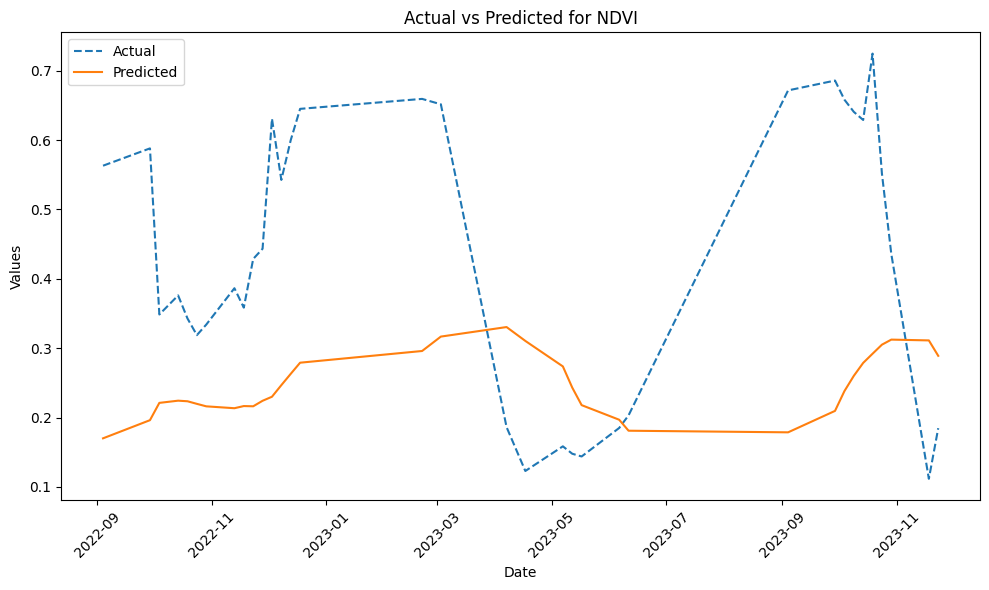

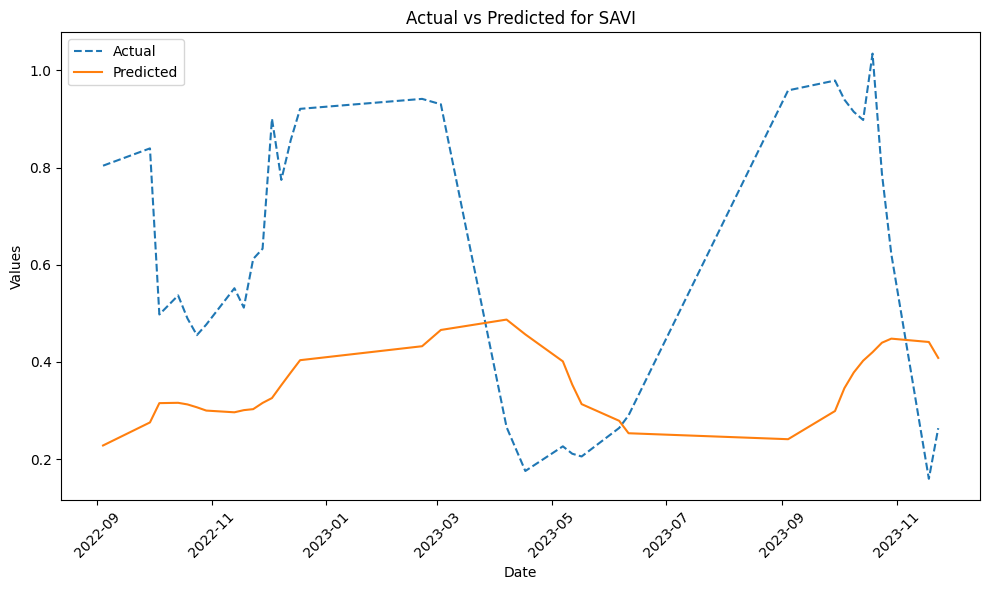

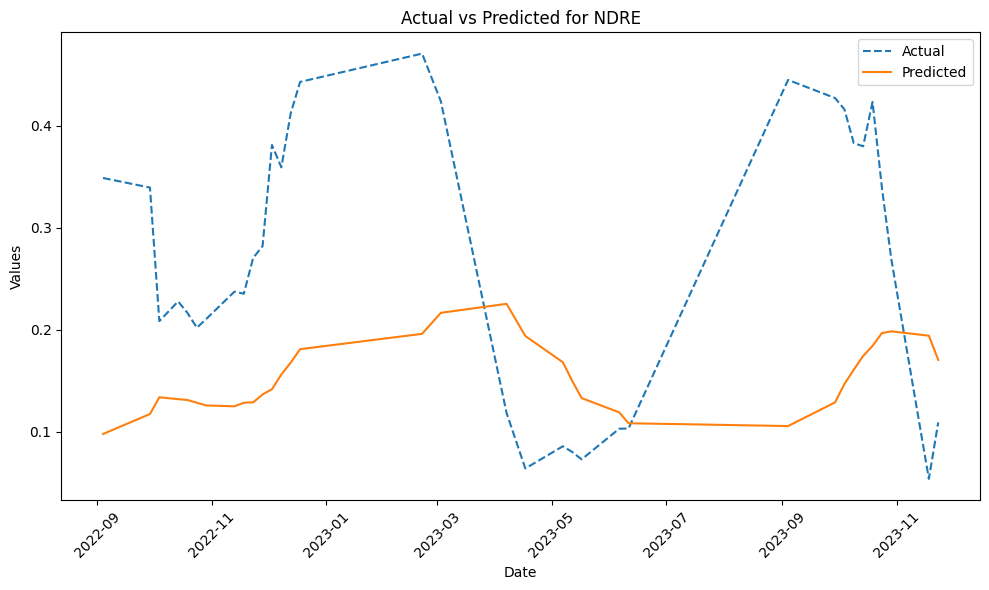

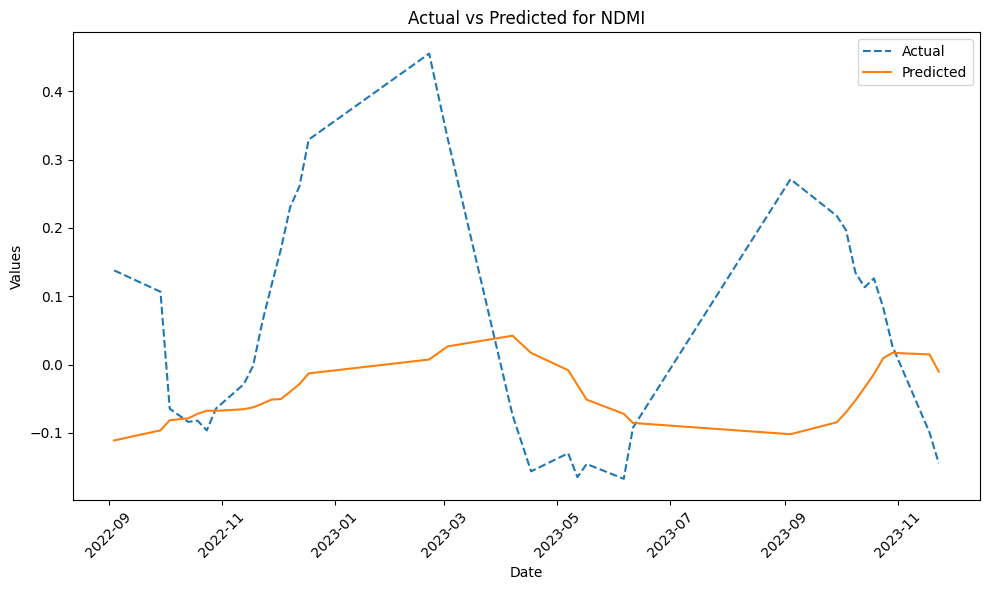

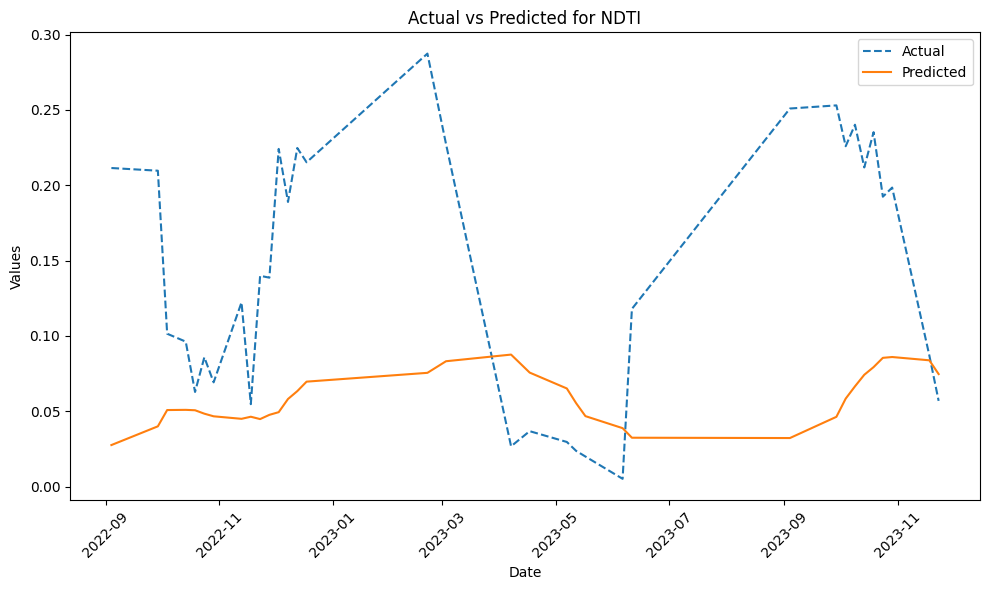

In [ ]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataf1)

# Split the data into train and test sets
test_size = int(len(scaled_data) * 0.2)
train_data, test_data = scaled_data[:test_size], scaled_data[test_size:]

def prepare_sequences_and_labels(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)

    X = np.array(sequences)
    y = np.array(labels)
    return X, y

# Prepare sequnces and labels
seq_length = 10
X_train, y_train = prepare_sequences_and_labels(train_data, seq_length)
X_test, y_test = prepare_sequences_and_labels(test_data, seq_length)
# Extract the date values corresponding to the sequences
sequence_dates = dataf1.index.values[seq_length:]

# Build the LSTM model
model = Sequential(name='lstm_pred_model')
model.add(LSTM(50,activation='relu', input_shape=(seq_length, X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
epochs =100
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=3,
                    validation_data=(X_test, y_test))

model.save('lstm_pred_model.h5')

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Make predictions on the test data
test_predict = model.predict(X_test, batch_size=1)

# Inverse transform to get actual values
actual_values = scaler.inverse_transform(y_test[:len(test_predict)])
predicted_values = scaler.inverse_transform(test_predict)

# Create a DataFrame to store predicted values and dates
predicted_df = pd.DataFrame(index=dataf1.index[-len(test_predict):])

# Compare actual and predicted values visually
columns_to_plot = ['NDVI', 'SAVI', 'NDRE', 'NDMI', 'NDTI']
for column_name in columns_to_plot:
    actual_column_values = actual_values[:, columns_to_plot.index(column_name)]
    predicted_column_values = predicted_values[:, columns_to_plot.index(column_name)]
    predicted_df[f'Predicted_{column_name}'] = predicted_column_values

    # Use the extracted test dates for plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dataf1.index[test_size + seq_length:], actual_column_values, label='Actual', linestyle='--')
    plt.plot(dataf1.index[test_size + seq_length:], predicted_column_values, label='Predicted')


    plt.title(f'Actual vs Predicted for {column_name}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()
    plt.show()

predicted_df.to_csv('predicted_values.csv')









In [ ]:

from tensorflow.keras.models import load_model
print(predicted_df.columns)

# Define the necessary variables
num_forecasts = 10
num_features = 5
sequence_length = 10  # Adjust this as needed
columns_to_plot = ['NDVI', 'SAVI', 'NDRE', 'NDMI', 'NDTI']

# Load your trained model
model = load_model('lstm_pred_model.h5')  # Replace with loading your trained model

# Assuming you have a DataFrame named dataf1
# Replace this with your actual data
dataf1 = df  # Your data

# Prepare input sequences for future predictions
future_input_sequences = prepare_sequences_and_labels(dataf1[['NDVI', 'SAVI', 'NDRE', 'NDMI',
       'NDTI']].values, sequence_length)

# Extract the last sequence from the historical data
last_sequence = dataf1[['NDVI', 'SAVI', 'NDRE', 'NDMI',
       'NDTI']].values[-seq_length:]

# Normalize the input sequences
scaler = MinMaxScaler()
scaler.fit(last_sequence)
future_input_sequence_scaled = scaler.transform(last_sequence)

# Make recursive predictions for future dates
future_predictions = []

for _ in range(num_forecasts):
    current_prediction = model.predict(np.array([future_input_sequence_scaled]))[0]
    future_predictions.append(current_prediction)
    future_input_sequence_scaled = np.roll(future_input_sequence_scaled, -1, axis=0)
    future_input_sequence_scaled[-1] = current_prediction

# Inverse transform the predictions to get actual values
future_predictions = np.array(future_predictions)
future_predicted_values = scaler.inverse_transform(future_predictions)

# Generate future dates
last_date = dataf1.index[-1]
future_dates = pd.date_range(start=last_date, periods=num_forecasts + 1, freq='5D')[1:]
future_dates = future_dates.strftime('%Y-%m-%d')  # Convert dates to string format

# Create a DataFrame with the predicted values and forecasted dates
columns_to_plot = ['NDVI', 'SAVI', 'NDRE', 'NDMI', 'NDTI']
future_predicted_df = pd.DataFrame(future_predicted_values, columns=columns_to_plot)
future_predicted_df['Date'] = future_dates
future_predicted_df.set_index('Date', inplace=True)

# Save the future predicted DataFrame to a CSV file
future_predicted_df.to_csv('future_predicted_values2.csv')

Index(['Predicted_NDVI', 'Predicted_SAVI', 'Predicted_NDRE', 'Predicted_NDMI',
       'Predicted_NDTI'],
      dtype='object')
1/1 [==============================] - 0s 34ms/step


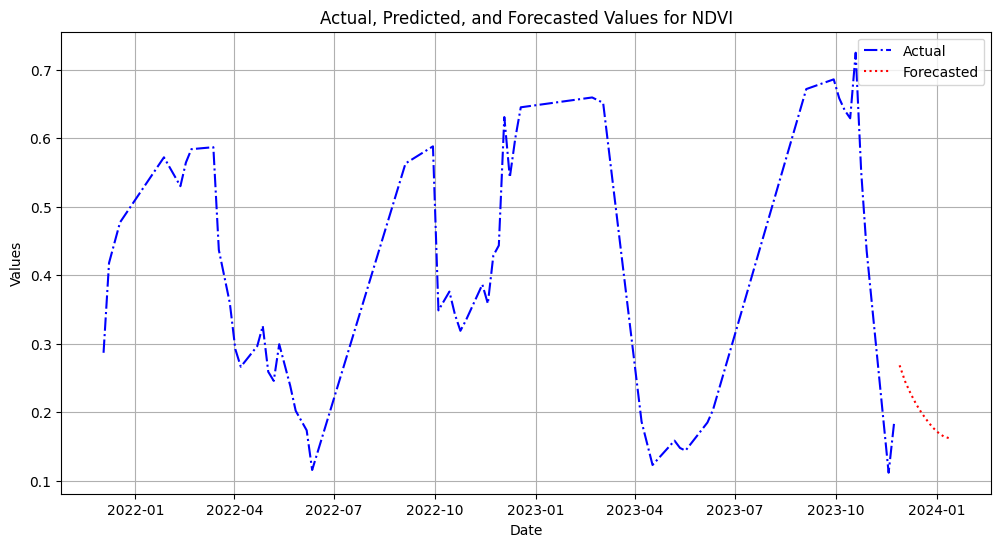

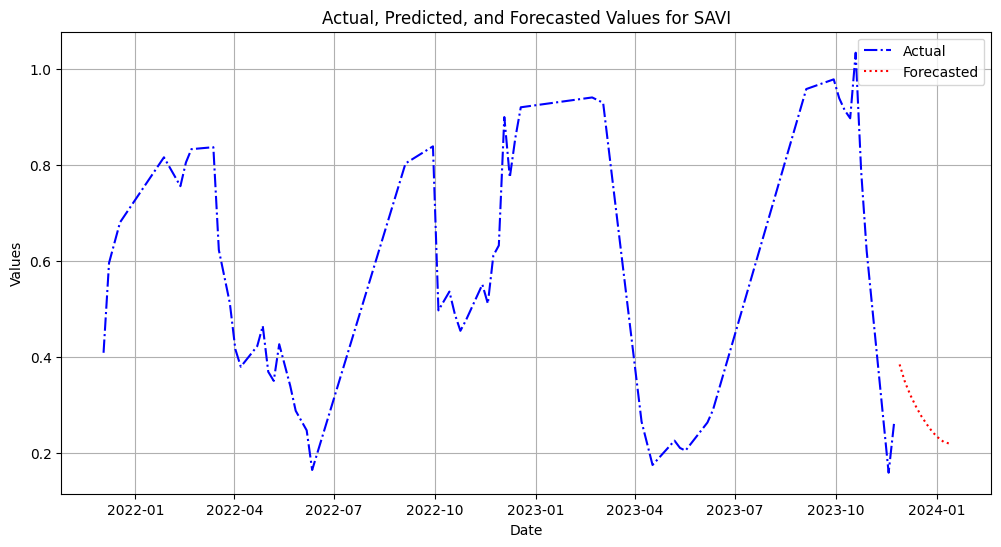

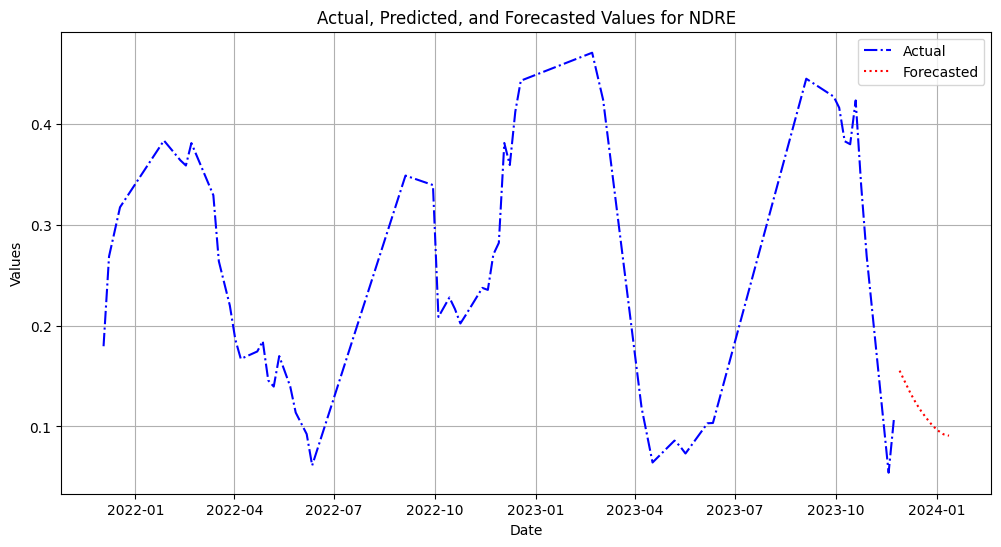

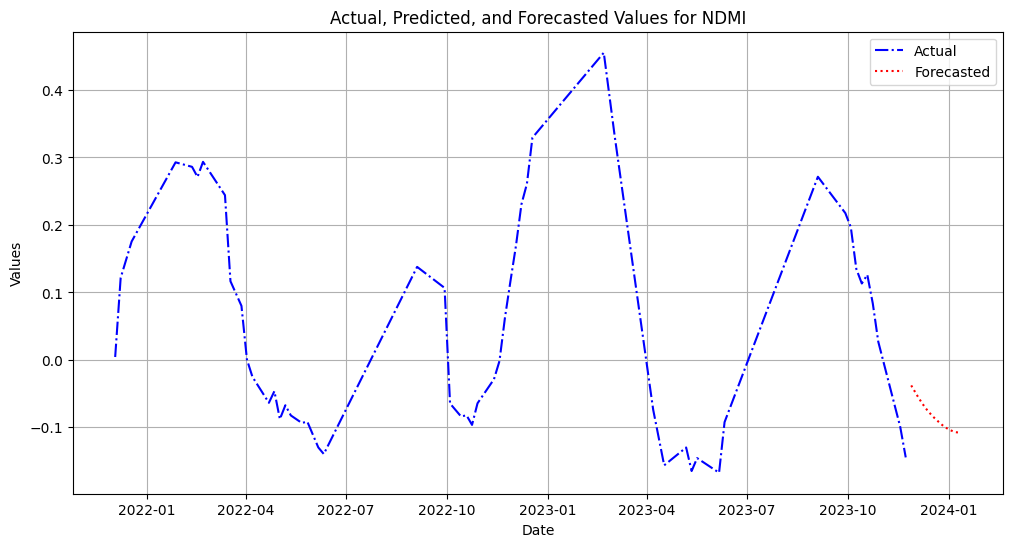

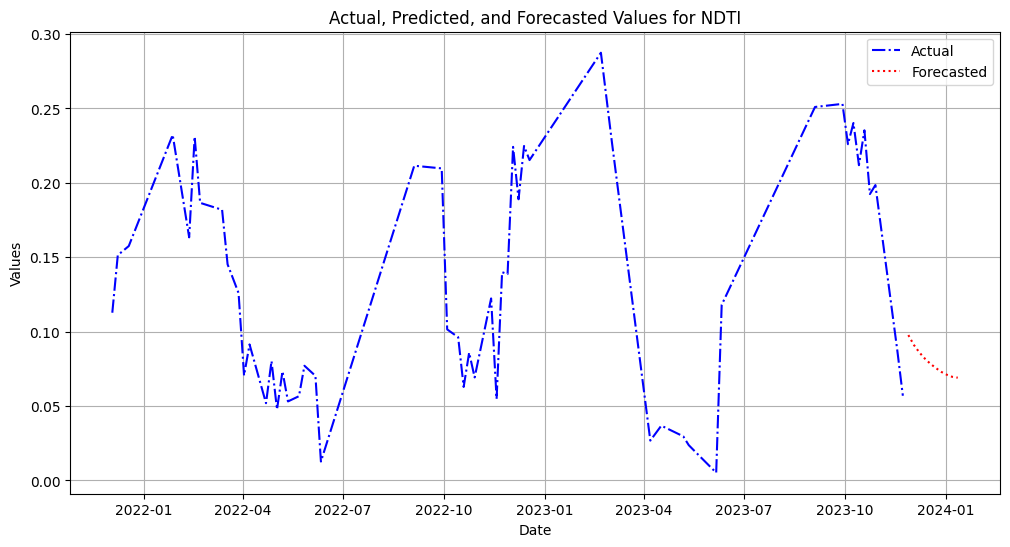

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the date strings to datetime objects
dataf1.index = pd.to_datetime(dataf1.index)
future_predicted_df.index = pd.to_datetime(future_predicted_df.index)
predicted_df.index = pd.to_datetime(predicted_df.index)  # Convert the index to datetime

# List of columns to plot
columns_to_plot = ['NDVI', 'SAVI', 'NDRE', 'NDMI', 'NDTI']

# Loop through each column and create individual plots
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(dataf1.index, dataf1[column], label='Actual', color='blue', linestyle='-.')

    # # Plot predicted values
    # predicted_column_name = f'Predicted_{column}'
    # plt.plot(predicted_df.index, predicted_df[predicted_column_name], label='Predicted', color='yellow', linestyle='solid')

    # Plot forecasted values
    plt.plot(future_predicted_df.index, future_predicted_df[column], label='Forecasted', color='red', linestyle=':')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Actual, Predicted, and Forecasted Values for {column}')

    # Add legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


Algorithm for peak detection




Total number of detected peaks in ndvi : 5
Total number of detected peaks in savi: 5
Total number of detected peaks in ndti: 4
Total number of detected peaks ndre: 4


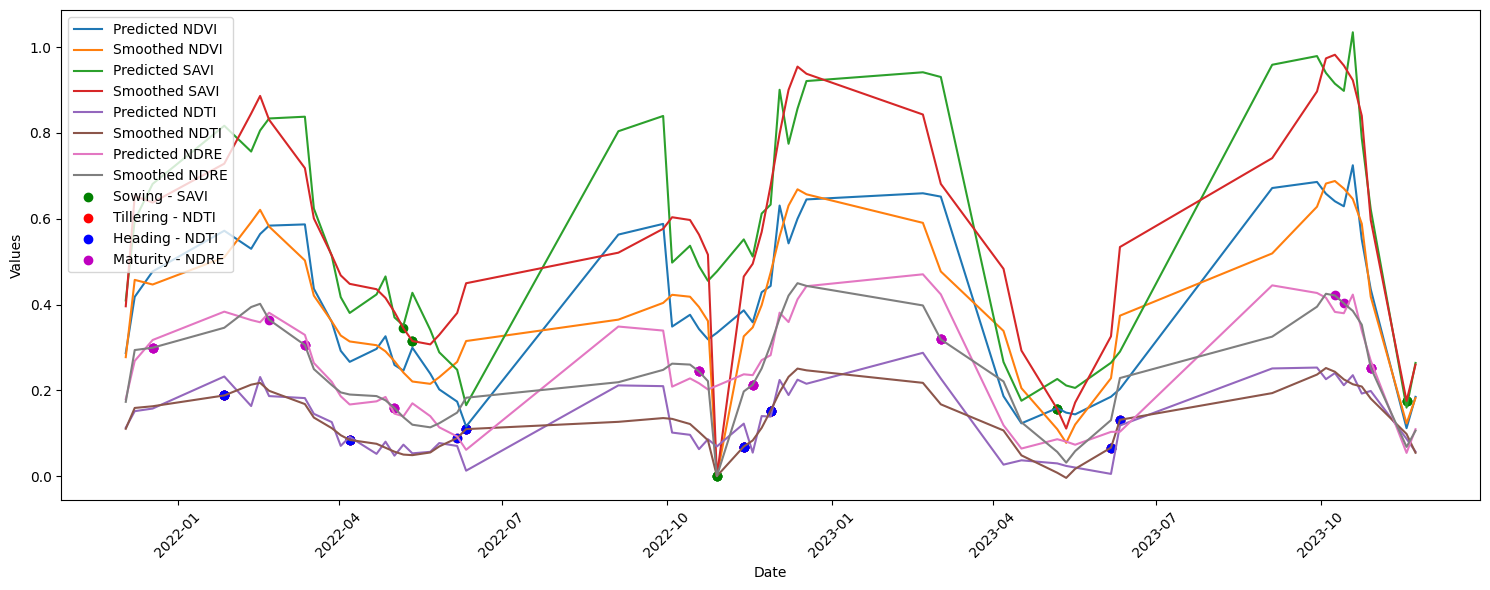

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
from datetime import datetime

# Load forecasted values from the CSV file
forecasted_df = pd.read_csv('/content/indices1.csv')  # Update with your file path

# Extract vegetation indices and date from the forecasted DataFrame
savi_values = forecasted_df['SAVI'].values
ndti_values = forecasted_df['NDTI'].values
predicted_ndvi_values = forecasted_df['NDVI'].values
ndre_values = forecasted_df['NDRE'].values

dates = forecasted_df['Date'].values  # Assuming you have a 'Date' column in your CSV
# Convert date strings to datetime format
date_format = '%Y-%m-%d'
time_index = [datetime.strptime(date_str, date_format) for date_str in dates]

# Parameters
cropcyclelength = 365 # days
npeaks = 1 # Number of peaks expected in the input signature

# Apply SG filter for NDVI data
window_length_ndvi = min(len(predicted_ndvi_values),361)  # Choose a suitable window length
window_length_savi = min(len(savi_values), 361)
window_length_ndti = min(len(ndti_values), 361)
window_length_ndre = min(len(ndre_values), 361)


smoothed_ndvi = savgol_filter(predicted_ndvi_values, window_length=window_length_ndvi, polyorder=15)
smoothed_savi = savgol_filter(savi_values, window_length=window_length_savi, polyorder=15)
smoothed_ndti = savgol_filter(ndti_values, window_length=window_length_ndti, polyorder=15)
smoothed_ndre = savgol_filter(ndre_values, window_length=window_length_ndre, polyorder=15)

# Compute first order and second order derivatives
first_derivative_ndvi = np.gradient(smoothed_ndvi)
second_derivative_ndvi = np.gradient(first_derivative_ndvi)

first_derivative_savi = np.gradient(smoothed_savi)
second_derivative_savi = np.gradient(first_derivative_savi)

first_derivative_ndti = np.gradient(smoothed_ndti)
second_derivative_ndti = np.gradient(first_derivative_ndti)

first_derivative_ndre = np.gradient(smoothed_ndre)
second_derivative_ndre = np.gradient(first_derivative_ndre)


# Find peaks in the smoothed NDVI data
peaks_ndvi, _ = find_peaks(smoothed_ndvi, height=0)
peaks_savi, _ = find_peaks(smoothed_savi, height=0)
peaks_ndti, _ = find_peaks(smoothed_ndti, height=0)
peaks_ndre, _ = find_peaks(smoothed_ndre, height=0)


# Print the total number of detected peaks
print(f"Total number of detected peaks in ndvi : {len(peaks_ndvi)}")
print(f"Total number of detected peaks in savi: {len(peaks_savi)}")
print(f"Total number of detected peaks in ndti: {len(peaks_ndti)}")
print(f"Total number of detected peaks ndre: {len(peaks_ndre)}")

# Initialize lists to store identified points
# Initialize lists to store identified points for all indices
sowing_points = {'savi':[]}
tillering_points = {'ndti':[]}
heading_points = {'ndvi':[]}
maturity_points = {'ndre':[]}


# Define a dictionary to map index names to their smoothed values and derivatives
index_data = {
    'ndvi': {'smoothed': smoothed_ndvi, 'first_derivative': first_derivative_ndvi, 'second_derivative': second_derivative_ndvi},
    'savi': {'smoothed': smoothed_savi, 'first_derivative': first_derivative_savi, 'second_derivative': second_derivative_savi},
    'ndti': {'smoothed': smoothed_ndti, 'first_derivative': first_derivative_ndti, 'second_derivative': second_derivative_ndti},
    'ndre': {'smoothed': smoothed_ndre, 'first_derivative': first_derivative_ndre, 'second_derivative': second_derivative_ndre}
}

# Identify points based on zero crossings and peak values
# Loop through each index to identify points based on derivatives
for index_name, index_values in index_data.items():
    first_derivative = index_values['first_derivative']
    second_derivative = index_values['second_derivative']

    first_derivative_zero_crossings = np.where(np.diff(np.sign(first_derivative)))[0]
    second_derivative_zero_crossings = np.where(np.diff(np.sign(second_derivative)))[0]


    for crossing_idx in first_derivative_zero_crossings:
       #or (first_derivative[crossing_idx] < 0)
        if (first_derivative_savi[crossing_idx] < 0):
            sowing_points['savi'].append(crossing_idx)
        else:
          #tillering_points['ndti'].append(crossing_idx)
          heading_points['ndvi'].append(crossing_idx)


    for crossing_idx in second_derivative_zero_crossings:
      # and (second_derivative[crossing_idx] < 0)
        if (second_derivative_ndvi[crossing_idx] < 0):
          maturity_points['ndre'].append(crossing_idx)
          #tillering_points['ndti'].append(crossing_idx)
        else :
          tillering_points['ndti'].append(crossing_idx)





# Assign stages based on peak values
if len(peaks_ndvi) >= npeaks:
    highest_peaks = sorted(peaks_ndvi, key=lambda idx: smoothed_ndvi[idx], reverse=True)[:npeaks]
elif len(peaks_savi) >=npeaks:
    highest_peaks=sorted(peaks_savi, key=lambda idx: smoothed_savi[idx], reverse=True)[:npeaks]
elif len(peaks_ndre)>=npeaks:
    highest_peaks=sorted(peaks_ndre,key=lambda idx: smoothed_ndre[idx], reverse=True)[:npeaks]
elif len(peaks_ndti)>=npeaks:
    highest_peaks=sorted(peaks_ndti,key=lambda idx: smoothed_ndti[idx], reverse=True)[:npeaks]
    stage_indices = {'Sowing': sowing_points, 'Tillering': tillering_points, 'Heading': heading_points, 'Maturity': maturity_points}
    stage_vegetation_indices = {'Sowing': savi_values, 'Tillering': ndti_values, 'Heading': predicted_ndvi_values, 'Maturity': ndre_values}

    for stage, indices in stage_indices.items():
        vegetation_index = stage_vegetation_indices[stage]
        for peak_idx in highest_peaks:
            if peak_idx in indices:
                print(f"{stage} stage identified at {time_index[peak_idx].date()} with peak {stage} value: {vegetation_index[peak_idx]}")



# Plot the results for visualization
plt.figure(figsize=(15, 6))
plt.plot(time_index, predicted_ndvi_values, label='Predicted NDVI')
plt.plot(time_index, smoothed_ndvi, label='Smoothed NDVI')

plt.plot(time_index, savi_values, label='Predicted SAVI')
plt.plot(time_index, smoothed_savi, label='Smoothed SAVI')

plt.plot(time_index, ndti_values, label='Predicted NDTI')
plt.plot(time_index, smoothed_ndti, label='Smoothed NDTI')

plt.plot(time_index, ndre_values, label='Predicted NDRE')
plt.plot(time_index, smoothed_ndre, label='Smoothed NDRE')


# Plot sowing points
'''
sowing_dates = [time_index[i] for i in sowing_points]
sowing_values = [smoothed_savi[i] for i in sowing_points]
plt.scatter(sowing_dates, sowing_values, color='g', marker='o', label='Sowing')
'''

# Plot sowing points
for index, indices in sowing_points.items():
    sowing_dates = [time_index[i] for i in indices]
    sowing_values = [index_data[index]['smoothed'][i] for i in indices]
    plt.scatter(sowing_dates, sowing_values, color='g', marker='o', label=f'Sowing - {index.upper()}')

# Plot tillering points
'''
tillering_dates = [time_index[i] for i in tillering_points]
tillering_values = [smoothed_ndti[i] for i in tillering_points]
plt.scatter(tillering_dates, tillering_values, color='r', marker='o', label='Tillering')
'''
for index, indices in tillering_points.items():
    tillering_dates = [time_index[i] for i in indices]
    tillering_values = [index_data[index]['smoothed'][i] for i in indices]
    plt.scatter(tillering_dates, tillering_values, color='r', marker='o', label=f'Tillering - {index.upper()}')



# Plot heading points
'''
heading_dates = [time_index[i] for i in heading_points]
heading_values = [smoothed_ndvi[i] for i in heading_points]
plt.scatter(heading_dates, heading_values, color='b', marker='o', label='Heading')
'''
for index, indices in tillering_points.items():
    heading_dates = [time_index[i] for i in indices]
    heading_values = [index_data[index]['smoothed'][i] for i in indices]
    plt.scatter(heading_dates, heading_values, color='b', marker='o', label=f'Heading - {index.upper()}')



# Plot maturity points
'''
maturity_dates = [time_index[i] for i in maturity_points]
maturity_values = [smoothed_ndre[i] for i in maturity_points]
plt.scatter(maturity_dates, maturity_values, color='m', marker='o', label='Maturity')
'''

for index, indices in maturity_points.items():
    maturity_dates = [time_index[i] for i in indices]
    maturity_values = [index_data[index]['smoothed'][i] for i in indices]
    plt.scatter(maturity_dates,maturity_values, color='m', marker='o', label=f'Maturity - {index.upper()}')



plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:


import matplotlib
print(matplotlib.__version__)

3.7.1


In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Create Plotly traces for each stage
traces = []
marker_size = 10

# Define hover text for each marker
sowing_hover_text = ['Sowing Point' for _ in sowing_points['savi']]
tillering_hover_text = ['Tillering Point' for _ in tillering_points['ndti']]
heading_hover_text = ['Vegetative Point' for _ in heading_points['ndvi']]
maturity_hover_text = ['Maturity Point' for _ in maturity_points['ndre']]


# Smoothed NDVI trace
trace_smoothed_ndvi = go.Scatter(x=time_index, y=smoothed_ndvi, mode='lines',line=dict(color='rgba(0, 128, 0, 0.8)',dash='solid',width=3), name='Vegetative')
traces.append(trace_smoothed_ndvi)

# Smoothed SAVI trace
trace_smoothed_savi = go.Scatter(x=time_index, y=smoothed_savi, mode='lines',line=dict(color='rgba(0, 0, 255, 0.8)',dash='dash',width=3), name='Sowing')
traces.append(trace_smoothed_savi)

# Smoothed NDTI trace
trace_smoothed_ndti = go.Scatter(x=time_index, y=smoothed_ndti, mode='lines',line=dict(color='rgba(255, 0, 0, 0.8)',dash='dot',width=3), name='Tillering')
traces.append(trace_smoothed_ndti)

# Smoothed NDRE trace
trace_smoothed_ndre = go.Scatter(x=time_index, y=smoothed_ndre, mode='lines', line=dict(color='rgba(165,42,42, 0.8)',dash='dashdot',width=3),name='Maturity')
traces.append(trace_smoothed_ndre)


# Sowing points for SAVI
trace_sowing_savi = go.Scatter(x=[time_index[i] for i in sowing_points['savi']], y=[smoothed_savi[i] for i in sowing_points['savi']],text=sowing_hover_text,mode='markers',  marker=dict(color='green', size=marker_size), name='Detected Sowing Point')
traces.append(trace_sowing_savi)

# Tillering points for NDTI
trace_tillering_ndti = go.Scatter(x=[time_index[i] for i in tillering_points['ndti']], y=[smoothed_ndti[i] for i in tillering_points['ndti']],text=tillering_hover_text, mode='markers', marker=dict(color='blue',size=marker_size), name='Detected Tillering Point')
traces.append(trace_tillering_ndti)

# Heading points for NDVI
trace_heading_ndvi = go.Scatter(x=[time_index[i] for i in heading_points['ndvi']], y=[smoothed_ndvi[i] for i in heading_points['ndvi']],text=heading_hover_text, mode='markers', marker=dict(color='purple',size=marker_size), name='Detected Vegetative Point')
traces.append(trace_heading_ndvi)

# Maturity points for NDRE
trace_maturity_ndre = go.Scatter(x=[time_index[i] for i in maturity_points['ndre']], y=[smoothed_ndre[i] for i in maturity_points['ndre']],text=maturity_hover_text, mode='markers', marker=dict(color='brown',size=marker_size), name='Detected Maturity Point')
traces.append(trace_maturity_ndre)



# Create the layout for the plot
layout = go.Layout(
    title='Crop Stage Detection',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Values'),
    showlegend=True,
    xaxis_tickformat='%Y-%m-%d',  # Set date format for x-axis
    xaxis_ticks='inside',  # Position x-axis ticks inside the plot
    xaxis_tickangle=-45, # Rotate x-axis labels for better visibility
    width=1200,  # Set the width of the graph (in pixels)
    height=600,
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Set background color to transparent
)

# # Calculate the number of years for the x-axis tick interval
# num_years = len(time_index) / 12

# # Set the x-axis tick interval to one year
# layout['xaxis']['nticks'] = num_years
# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()
